# Fair Value Gap - Analytics

### Import Library

In [31]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
import seaborn as sns
from candlestick import WHITE_CS, BLACK_CS, DOJI_CS
import candlestick.price_action as pa

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [32]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [33]:
data = dataset.copy()

In [34]:
data = pa.pattern_modeling(data, 'reversal')

In [35]:
data['min_3_low'] = data['Low'].rolling(3).min()
data['max_3_high'] = data['High'].rolling(3).max()

In [36]:
data.dropna(inplace=True)

In [37]:
data

,Open,High,Low,Close,Volume,min_OC,max_OC,upper_wick,tail,oc_dif,body,color,candlestick,model,min_3_low,max_3_high
Date,,,,,,,,,,,,,,,,
2018-08-13 09:10:00,943.2,943.3,942.6,943.1,1207,943.1,943.2,0.1,0.5,-0.1,0.1,black,,-,942.6,943.6
2018-08-13 09:15:00,943.1,943.1,942.3,942.6,1196,942.6,943.1,0.0,0.3,-0.5,0.5,black,,-,942.3,943.5
2018-08-13 09:20:00,942.6,943.7,942.4,943.7,1765,942.6,943.7,0.0,0.2,1.1,1.1,white,,-,942.3,943.7
2018-08-13 09:25:00,943.8,945.9,943.7,945.3,2469,943.8,945.3,0.6,0.1,1.5,1.5,white,,,942.3,945.9
2018-08-13 09:30:00,945.2,945.5,943.9,944.0,1668,944.0,945.2,0.3,0.1,-1.2,1.2,black,,,942.4,945.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-18 14:15:00,1310.7,1313.5,1308.7,1312.8,8783,1310.7,1312.8,0.7,2.0,2.1,2.1,white,,bullish_engulfing,1308.7,1313.5
2024-09-18 14:20:00,1312.8,1313.2,1310.8,1311.3,6209,1311.3,1312.8,0.4,0.5,-1.5,1.5,black,,,1308.7,1313.5
2024-09-18 14:25:00,1311.1,1313.3,1311.1,1311.2,5452,1311.1,1311.2,2.1,0.0,0.1,0.1,white,inverted_hammer,,1308.7,1313.5


In [38]:
def has_bullish_pattern(model):
    if "bullish" in model or "rising" in model:
        return True
    return False


def has_bearish_pattern(model):
    if "bearish" in model or "falling" in model:
        return True
    return False

### Calculating return

In [39]:
RR = 3
def cal_return(data):
    data['return'] = ''
    data['exit_time'] = ''
    data['entry_price'] = ''
    data['exit_price'] = ''
    data['deal_type'] = ''
    data['sl_length'] = ''
    data['min_max_length'] = ''
    for i, row in data.iterrows():
        if 910 < 100*row.name.hour + row.name.minute < 1430:
            if row['model'] != '':
                _return = 0
                deal_type = ''
                current_date = row.name.strftime('%Y-%m-%d ').format()
                current_time = row.name
                entry_price = max_price = min_price = row['Close']
                data_from_start_day = data[(data.index < current_time) & (data.index > current_date + ' 08:59:00')]
                if 100*row.name.hour + row.name.minute < 1405:
                    if has_bullish_pattern(row['model']):
                        deal_type = 'long'
                        stoploss = row['min_3_low']
                        sl_length = entry_price - stoploss
                        min_max_length = entry_price - data_from_start_day['Low'].min()
                    elif has_bearish_pattern(row['model']):
                        deal_type = 'short'
                        stoploss = row['max_3_high']
                        sl_length = stoploss - entry_price
                        min_max_length = data_from_start_day['High'].max() - entry_price
                exit_time = ''
                exit_price = 0
                data_to_end_day = data[(data.index > current_time) & (data.index < current_date + ' 14:30:00')]
                for k, wrow in data_to_end_day.iterrows():
                    if deal_type == 'long':
                        if wrow['Low'] < stoploss:
                            # if max_price >= entry_price + RR * sl_length:
                            #     # Take profit
                            #     _return = RR * sl_length
                            #     exit_time = wrow.name
                            #     exit_price = entry_price + RR * sl_length
                            # else:
                                # Stoploss
                            if max_price < entry_price + sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = stoploss - entry_price
                                exit_time = wrow.name
                                exit_price = wrow['Low']
                            else:
                                _return = max_price - entry_price
                            break
                        else:
                            if wrow['High'] > max_price:
                                max_price = wrow['High']
                                exit_time  = wrow.name
                                exit_price = max_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = max_price - entry_price
                                break
                    if deal_type == 'short':
                        if wrow['High'] > stoploss:
                            if min_price > entry_price - sl_length:
                                # if profit >= stoploss, keep deal as has profit
                                # else do stoploss
                                _return = entry_price - stoploss
                                exit_time = wrow.name
                                exit_price = stoploss
                            else:
                                _return = entry_price - min_price
                            break
                        else:
                            if wrow['Low'] < min_price:
                                min_price = wrow['Low']
                                exit_time  = wrow.name
                                exit_price = min_price
                            if 100*row.name.hour + row.name.minute == 1425:
                                _return = entry_price - min_price
                                break
                if deal_type != '':
                    data.at[i, 'deal_type'] = deal_type
                    data.at[i, 'entry_price'] = entry_price
                    data.at[i, 'return'] = _return
                    data.at[i, 'exit_price'] = exit_price
                    data.at[i, 'exit_time'] = exit_time
                    data.at[i, 'sl_length'] = sl_length
                    data.at[i, 'min_max_length'] = min_max_length
    return data

In [40]:
%%time
data = cal_return(data)

CPU times: user 47.5 s, sys: 44.5 ms, total: 47.6 s
Wall time: 47.9 s


In [41]:
has_return = data[(data['return'] != '') & (data['return'] != 0)]

In [42]:
has_return

,Open,High,Low,Close,Volume,min_OC,max_OC,upper_wick,tail,oc_dif,...,model,min_3_low,max_3_high,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,,,,,,,
2018-08-13 09:40:00,943.8,944.8,943.3,944.5,1722,943.8,944.5,0.3,0.5,0.7,...,bullish_tasuki_line,943.3,945.5,1.9,2018-08-13 09:55:00,944.5,946.4,long,1.2,2.2
2018-08-13 09:55:00,946.2,946.4,945.6,946.0,1873,946.0,946.2,0.2,0.4,-0.2,...,bearish_meeting_line,944.3,946.4,3.7,2018-08-13 10:50:00,946.0,942.3,short,0.4,0.0
2018-08-13 10:20:00,945.3,945.5,943.8,944.0,1245,944.0,945.3,0.2,0.2,-1.3,...,bearish_engulfing,943.8,945.7,1.7,2018-08-13 10:50:00,944.0,942.3,short,1.7,2.4
2018-08-13 10:35:00,943.9,944.9,943.9,944.8,1101,943.9,944.8,0.1,0.0,0.9,...,bullish_tasuki_line,943.5,944.9,-1.3,2018-08-13 10:45:00,944.8,942.9,long,1.3,2.5
2018-08-13 10:40:00,944.9,945.0,943.7,943.7,936,943.7,944.9,0.1,0.0,-1.2,...,bearish_engulfing,943.5,945.0,1.4,2018-08-13 10:50:00,943.7,942.3,short,1.3,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-18 10:45:00,1315.8,1315.8,1314.1,1314.2,6950,1314.2,1315.8,0.0,0.1,-1.6,...,bearish_tweezers_top,1310.1,1315.8,2.2,2024-09-18 10:55:00,1314.2,1312.0,short,1.6,1.6
2024-09-18 11:00:00,1312.3,1313.5,1312.3,1313.4,3899,1312.3,1313.4,0.1,0.0,1.1,...,bullish_engulfing,1312.0,1314.3,5.1,2024-09-18 13:00:00,1313.4,1318.5,long,1.4,10.2
2024-09-18 11:30:00,1317.0,1317.0,1316.9,1316.9,57,1316.9,1317.0,0.0,0.0,-0.1,...,bearish_meeting_line,1314.3,1317.0,-0.1,2024-09-18 13:00:00,1316.9,1317.0,short,0.1,0.1


In [43]:
has_return['return'].sum()

2928.3999999999633

In [44]:
long = has_return[has_return['deal_type'] == 'long']

In [45]:
long.tail(30)

,Open,High,Low,Close,Volume,min_OC,max_OC,upper_wick,tail,oc_dif,...,model,min_3_low,max_3_high,return,exit_time,entry_price,exit_price,deal_type,sl_length,min_max_length
Date,,,,,,,,,,,,,,,,,,,,,
2024-09-05 14:00:00,1311.0,1312.5,1310.9,1311.9,6164,1311.0,1311.9,0.6,0.1,0.9,...,bullish_harami,1310.9,1314.3,1.0,2024-09-05 14:05:00,1311.9,1312.9,long,1.0,1.0
2024-09-06 09:15:00,1307.5,1308.4,1307.1,1308.4,2128,1307.5,1308.4,0.0,0.4,0.9,...,bullish_engulfing,1307.1,1308.4,-1.3,2024-09-06 09:25:00,1308.4,1305.6,long,1.3,1.3
2024-09-06 10:00:00,1309.9,1310.5,1309.8,1310.5,3342,1309.9,1310.5,0.0,0.1,0.6,...,bullish_tasuki_line,1309.5,1310.5,-1.0,2024-09-06 10:20:00,1310.5,1309.1,long,1.0,4.9
2024-09-06 10:25:00,1309.2,1309.6,1309.0,1309.5,1539,1309.2,1309.5,0.1,0.2,0.3,...,bullish_piercing,1309.0,1310.2,-0.5,2024-09-06 10:30:00,1309.5,1308.7,long,0.5,3.9
2024-09-06 11:05:00,1307.4,1307.5,1306.7,1307.5,2098,1307.4,1307.5,0.0,0.7,0.1,...,bullish_meeting_line,1306.7,1308.3,1.0,2024-09-06 13:05:00,1307.5,1308.5,long,0.8,1.9
2024-09-06 11:15:00,1307.2,1308.3,1307.1,1307.9,2322,1307.2,1307.9,0.4,0.1,0.7,...,bullish_engulfing,1306.7,1308.3,-1.2,2024-09-06 13:15:00,1307.9,1306.3,long,1.2,2.3
2024-09-06 13:55:00,1309.1,1310.0,1309.1,1309.9,1866,1309.1,1309.9,0.1,0.0,0.8,...,bullish_engulfing,1309.0,1310.0,1.4,2024-09-06 14:00:00,1309.9,1311.3,long,0.9,4.3
2024-09-09 10:10:00,1302.9,1303.3,1302.7,1303.0,920,1302.9,1303.0,0.3,0.2,0.1,...,bullish_tasuki_line,1302.2,1303.3,-0.8,2024-09-09 10:25:00,1303.0,1301.3,long,0.8,4.4
2024-09-09 11:25:00,1303.1,1303.8,1303.1,1303.8,1145,1303.1,1303.8,0.0,0.0,0.7,...,bullish_engulfing,1302.9,1303.8,3.4,2024-09-09 13:00:00,1303.8,1307.2,long,0.9,5.2


In [46]:
long['sl_length'] = long['sl_length'].astype(float)

In [47]:
long['sl_group'] = pd.qcut(long.sl_length, 20)

In [48]:
long['min_max_length'] = long['min_max_length'].astype(float)

In [49]:
long['return'] = long['return'].astype(float)

In [50]:
long['day_min_distance_group'] = pd.qcut(long.min_max_length, 20)

In [51]:
long['sl_length'].describe()

count    6174.000000
mean        1.770100
std         1.627289
min         0.000000
25%         0.700000
50%         1.300000
75%         2.200000
max        21.200000
Name: sl_length, dtype: float64

In [52]:
long['return'].describe()

count    6174.000000
mean        0.127033
std         3.809168
min       -21.200000
25%        -1.700000
50%        -0.700000
75%         1.700000
max        56.900000
Name: return, dtype: float64

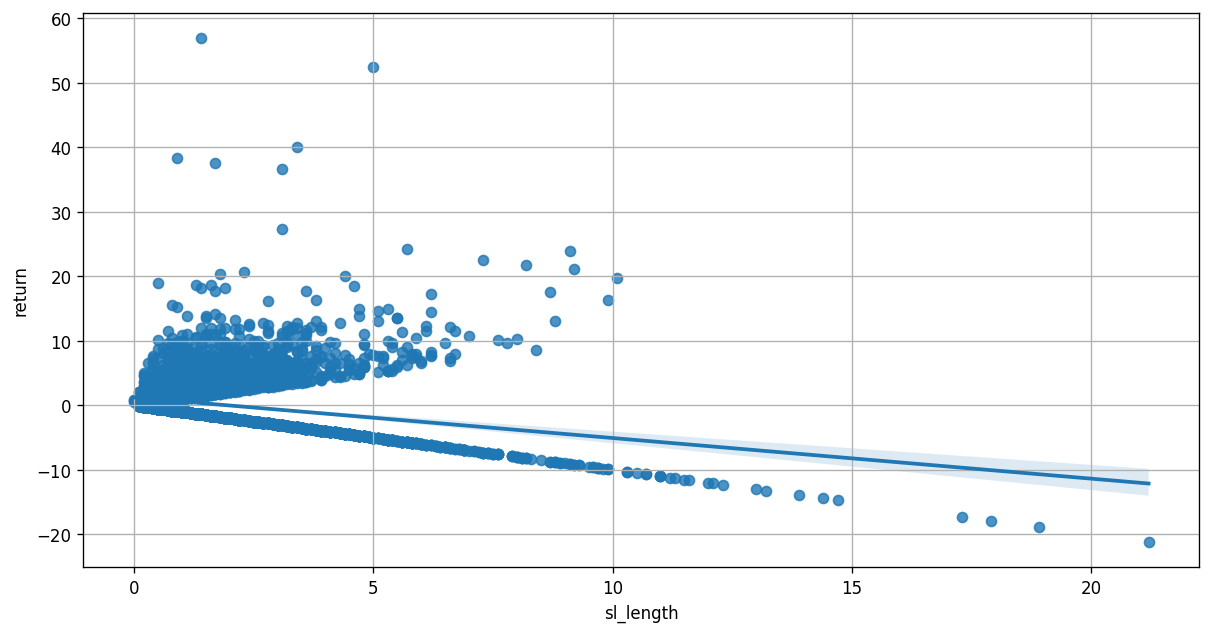

In [53]:
sns.regplot(x=long['sl_length'], y=long['return'])
plt.grid(True)

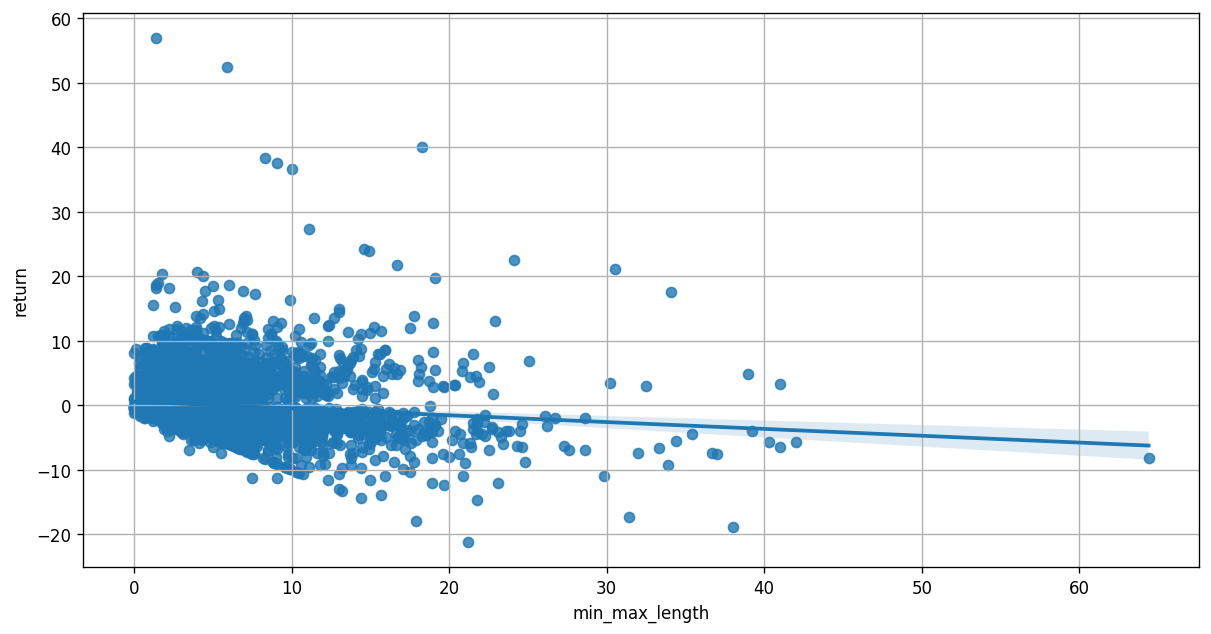

In [54]:
sns.regplot(x=long['min_max_length'], y=long['return'])
plt.grid(True)

<Axes: xlabel='day_min_distance_group', ylabel='sl_group'>

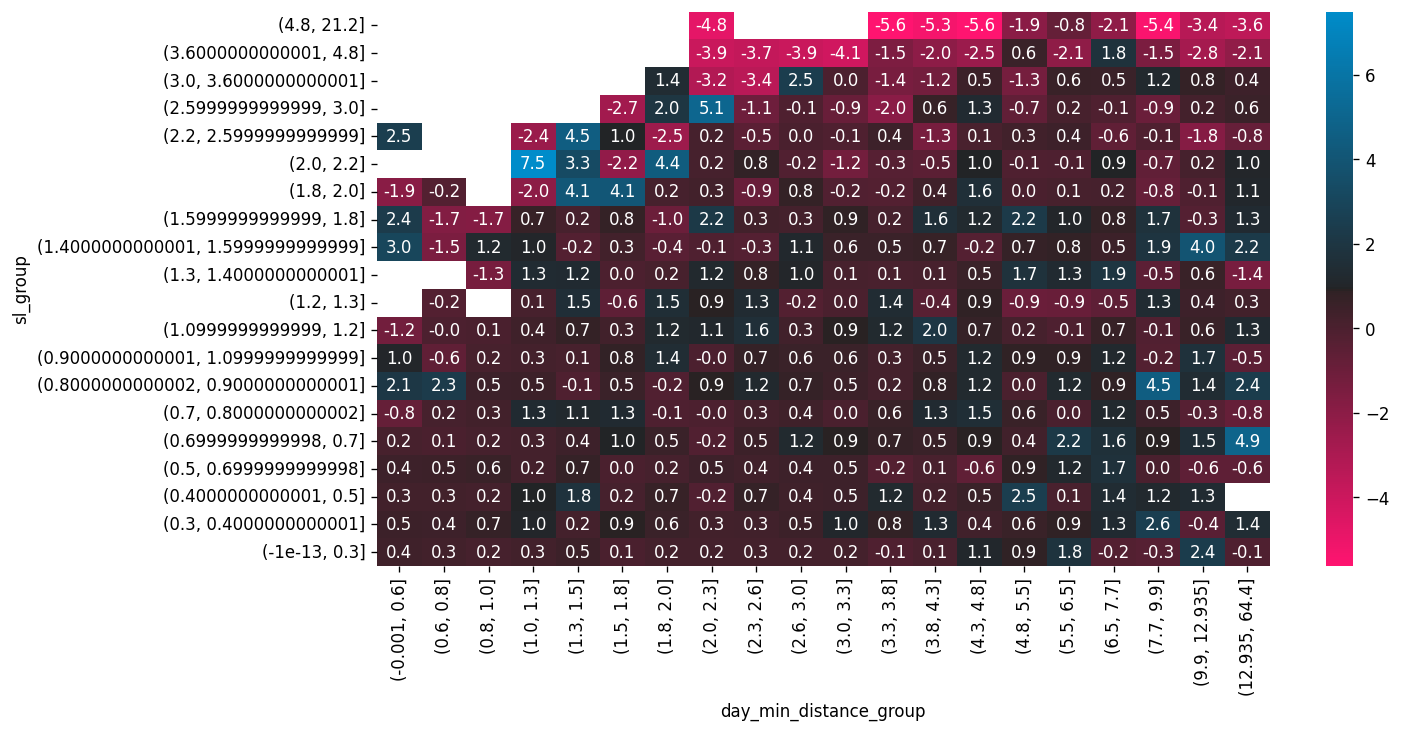

In [55]:
grpd = long.groupby(['sl_group', 'day_min_distance_group'])[['return']]
irs = grpd.mean().reset_index()
sns.heatmap(
    irs.pivot(index='sl_group', columns='day_min_distance_group', values='return').sort_index(ascending=False),
    cmap=sns.diverging_palette(0, 240, s=100, l=55, center="dark", as_cmap=True),
    annot=True, fmt=".1f")